<h1>Morphin' Time!</h1>

<p>I don't want to spoil the plan for this notebook, so we are going to jump right in and do as we stated we would, <b>train a Generative Adversarial Network</b> to generate images of handwritten digits like those in the MNIST dataset. One nice thing about this approach is we do not need to feed the model a sequence of pixels, as the GAN can easily produce entire images for us. This is actually one of the reasons I did <b>not</b> use one before; we are supposed to be approaching MNIST from an unusual perspective. 

Why do so now? Well, we are going to switch things up a bit after we train our initial model. ;D</p>

<p>A Generative Adverserial Network, or GAN, is great for creating images. It is a combination of two neural networks, a generator and a discriminator. The generator creates images that the discriminator is supposed to try an distinguish from real ones. They compete with each other, and the generator gets better at creating images that fool the discriminator.

What follows is a simple GAN architecture for generating MNIST images (kind of boring, I know, but please be patient for a little bit longer).</p>

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# Some constants for the GAN
# The number of epochs to train for, the batch size, the noise dimension, and the number of examples to generate
EPOCHS = 60
BATCH_SIZE = 128
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 100

In [46]:
# Let's import the MNIST dataset. We don't actually need the test images since we are creating our
# our images.
mnist = keras.datasets.mnist
(train_images, train_labels), (_, _) = mnist.load_data()

# We should probably also also normalize the data
train_images = (train_images - 127.5) / 127.5

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE)

In [47]:
# For the generator, we will use a simple fully connected network. We start with a 100 dimensional noise vector,
# and we will reshape it to a 7x7x256 tensor. We will then use a series of Conv2DTranspose layers to upsample
# the image to the size of the MNIST images a little bit at a time. The BatchNormalization layers should help
# with training stability. We will use the LeakyReLU activation function to help prevent gradient loss. 
# We will also use the tanh activation function for the output layer to ensure that the output vector
# only has values between -1 and 1 (since that is the range we normalized our values to). 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Reshape((7, 7, 256)),
    keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(),

    keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

In [48]:
# For the discriminator, we start with a series of Conv2D layers to downsample the image to a 7x7x64 tensor.
# We then flatten the tensor and use a Dense layer to get a single output value.
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

In [49]:
# We need to define the loss functions for the generator and discriminator. We will use the binary cross entropy for loss
# and the Adam optimizer for both. We should also make some checkpoints to save the model weights in case we want to
# pick up training later.
import os

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)

In [50]:
# We will define a function to train the model. We will use the tf.function decorator to compile the function
# into a callable TensorFlow graph. This should speed up training.
@tf.function
def train_step(images):
    # First, we will generate some random noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Let's use GradientTape to record the operations for the automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # We use the generator to generate some fake images
        generated_images = generator(noise, training=True)

        # Then we use the discriminator to get a prediction for the fake images and for the real images
        fake_output = discriminator(generated_images, training=True)
        real_output = discriminator(images, training=True)

        # Next we calculate the loss for both the generator and discriminator.
        # We want to generator to fool the discriminator, so we want the fake images to be classified as real (i.e., 1),
        # and we want the discriminator to correctly classify the real images as real and the fake images as fake, so
        # we want the discriminator to output 1 for the real images and 0 for the fake images.
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

    # Gotta keep track of the gradients!
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Lastly, we apply the gradients to the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [51]:
# We will make a function to train the model. We will also generate some images to see how the generator is doing during training.
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # We will save the model every 3 epochs
        if (epoch + 1) % 3 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
                
            # We should probably generate some images to see how the generator is doing as well
            generate_and_save_images(generator, epoch + 1)

# Here is the function for generating and saving images
def generate_and_save_images(model, epoch):
    # We will generate some random noise
    noise = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

    # We will use the generator to generate some 100 images to display every once in a while
    predictions = model(noise, training=False)

    # Let's plot them in a 5x20 grid
    fig = plt.figure(figsize=(20, 5))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 20, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch)) # We want to see how the images change over time
    plt.show()

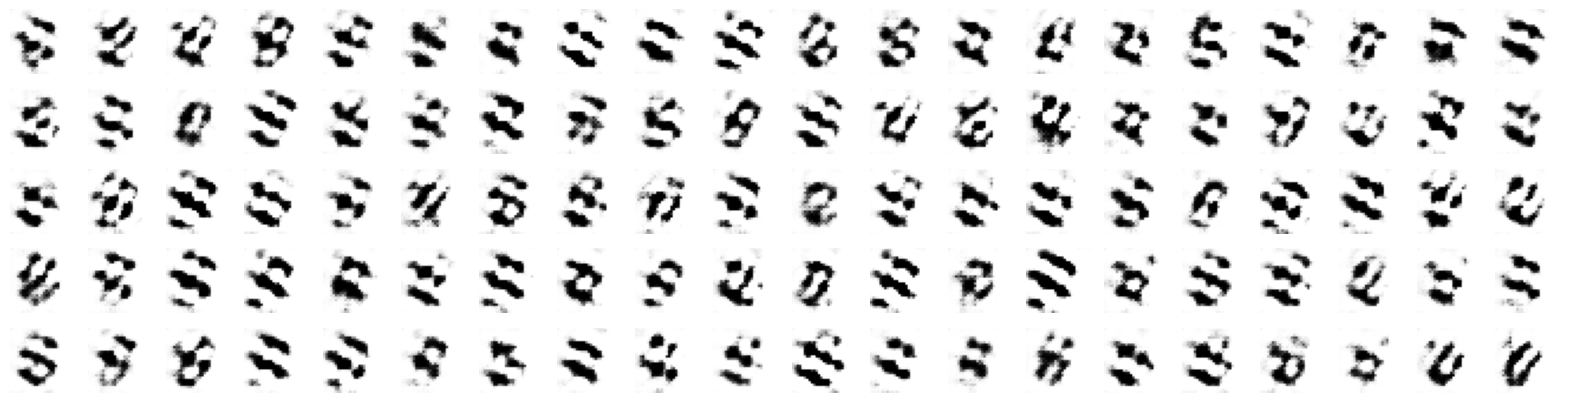

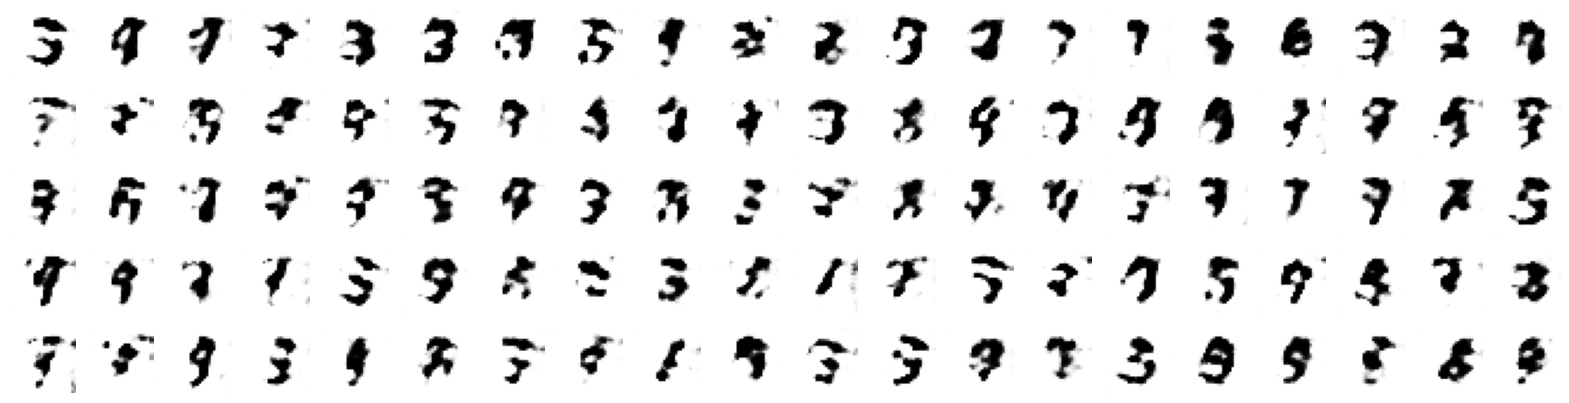

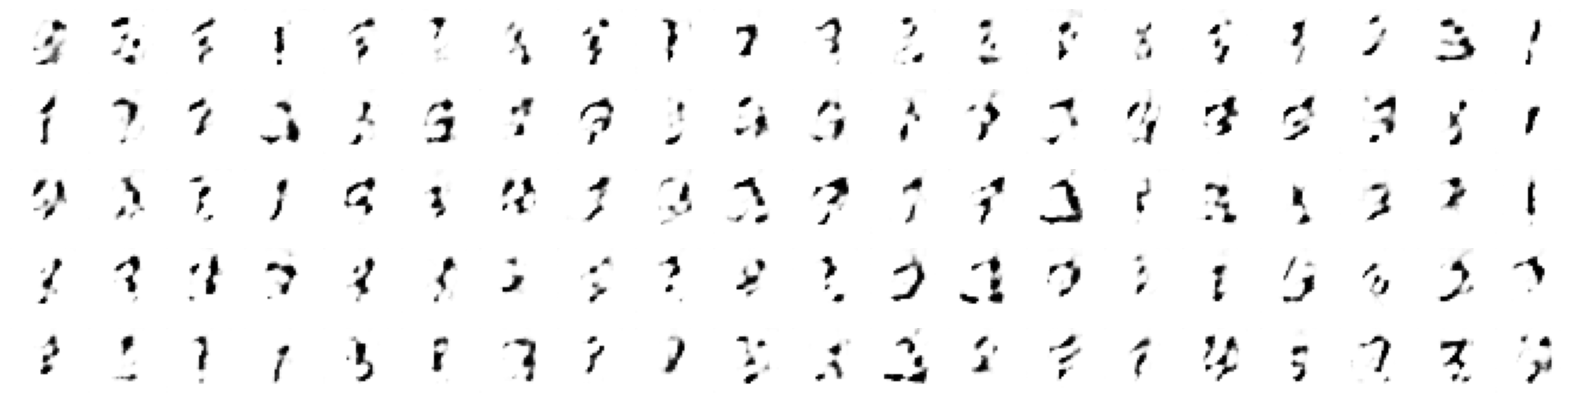

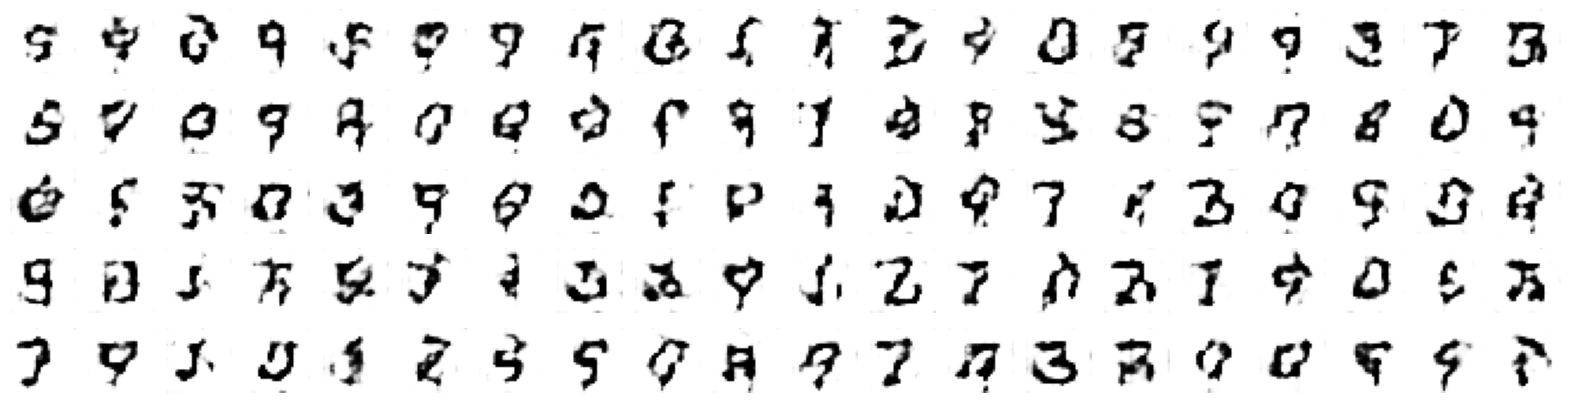

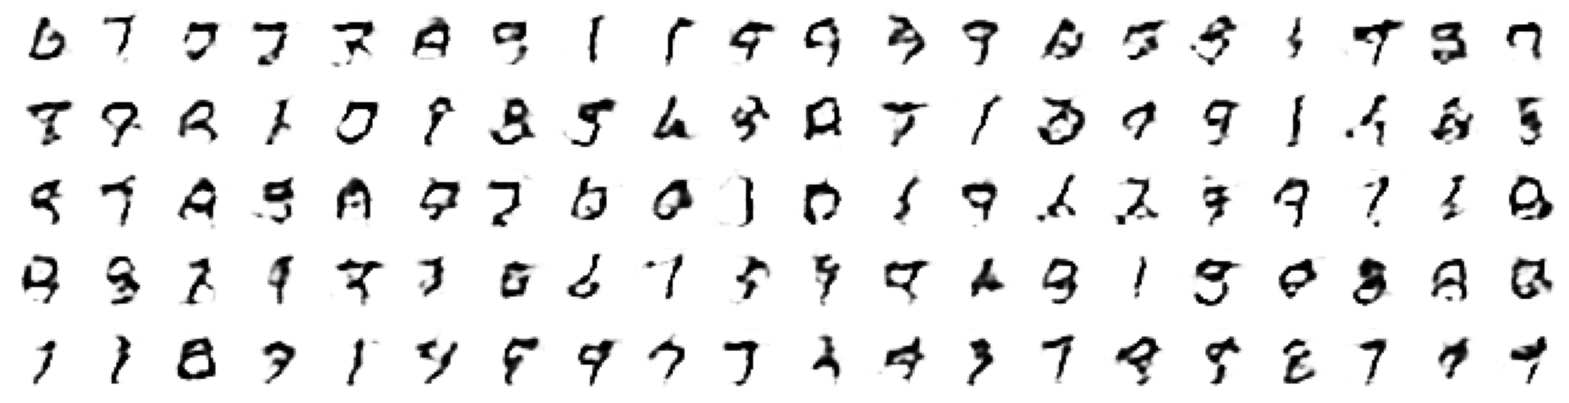

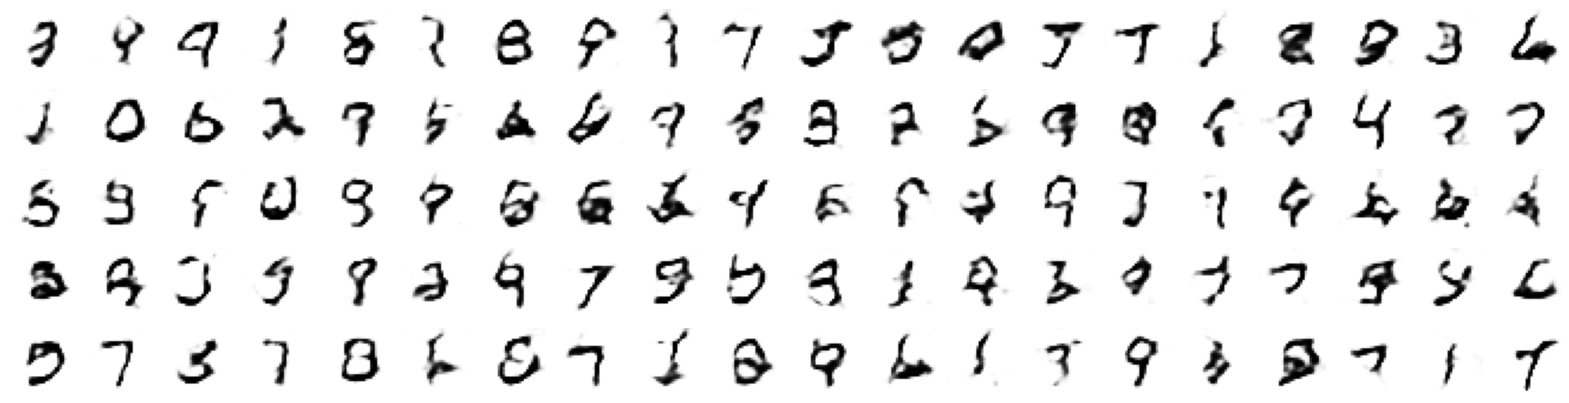

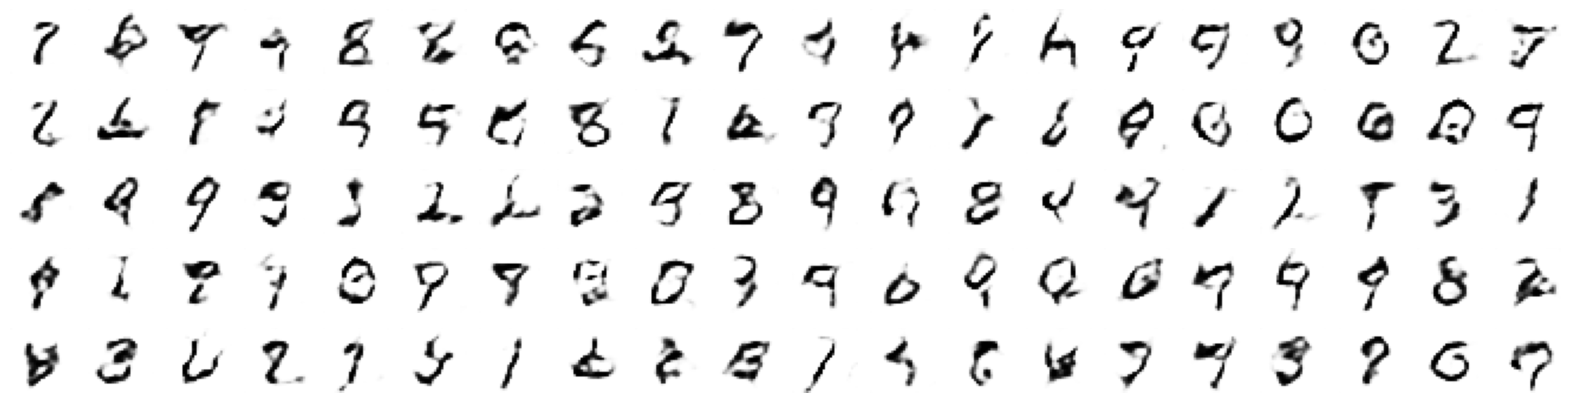

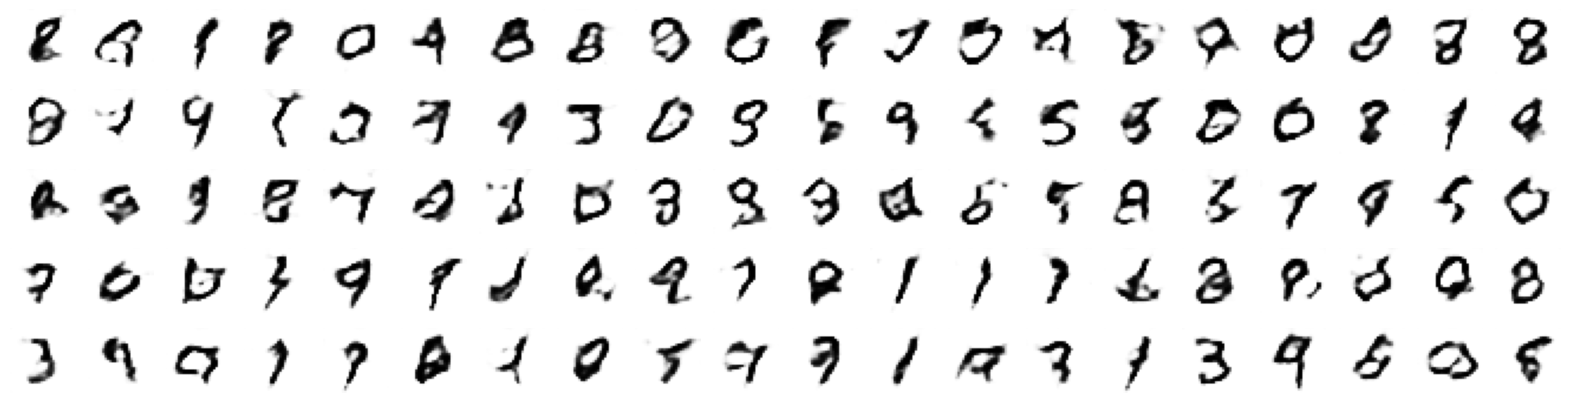

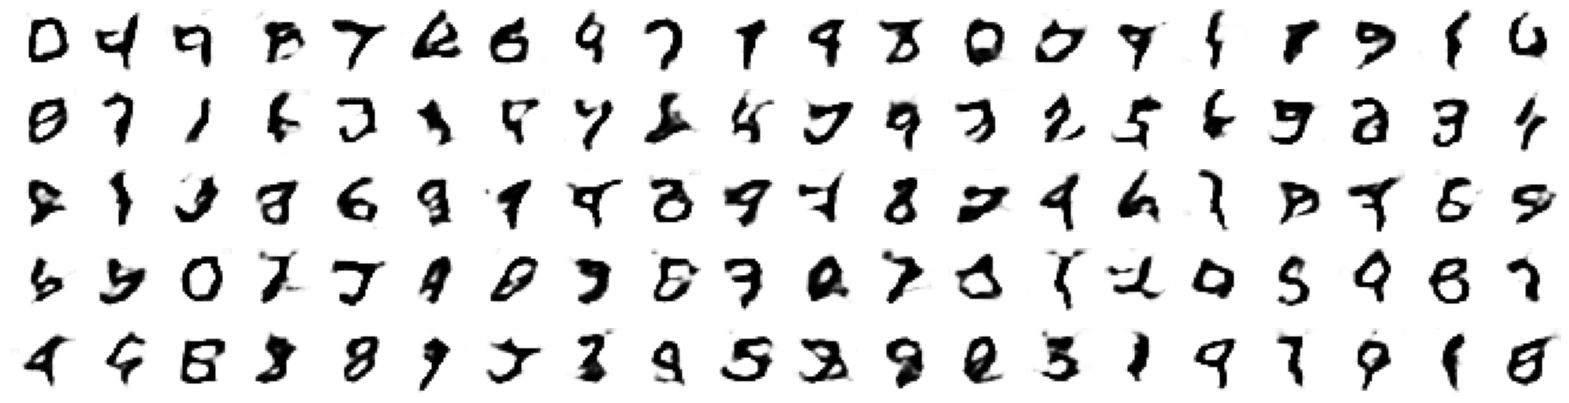

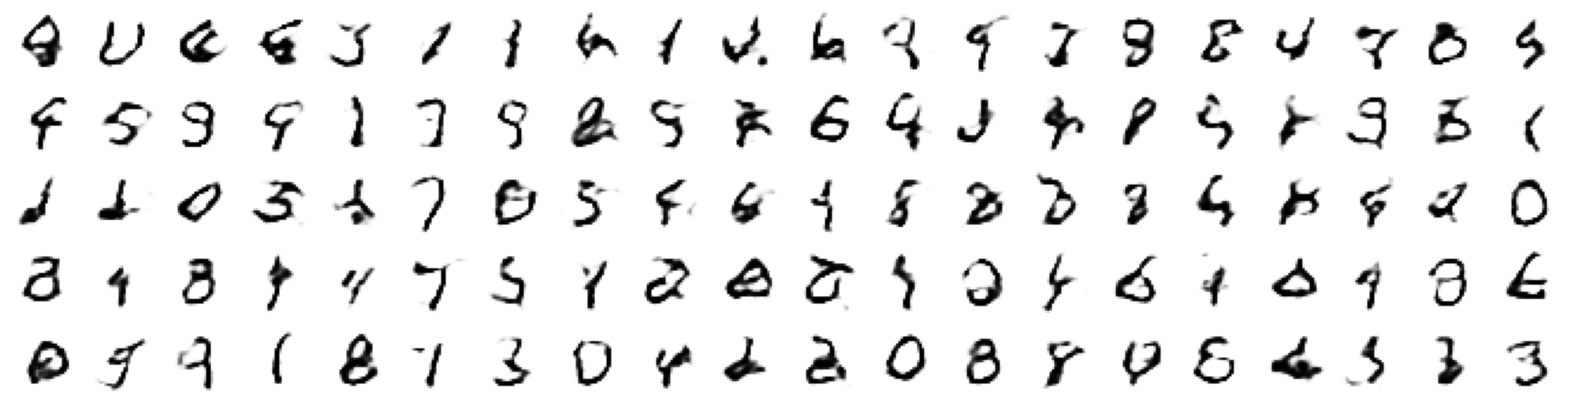

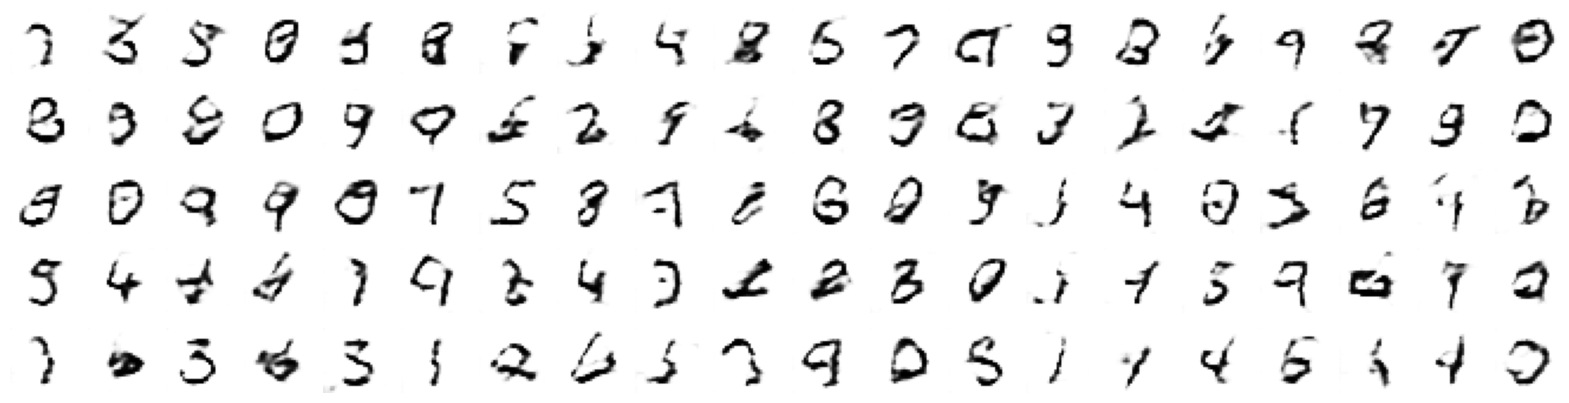

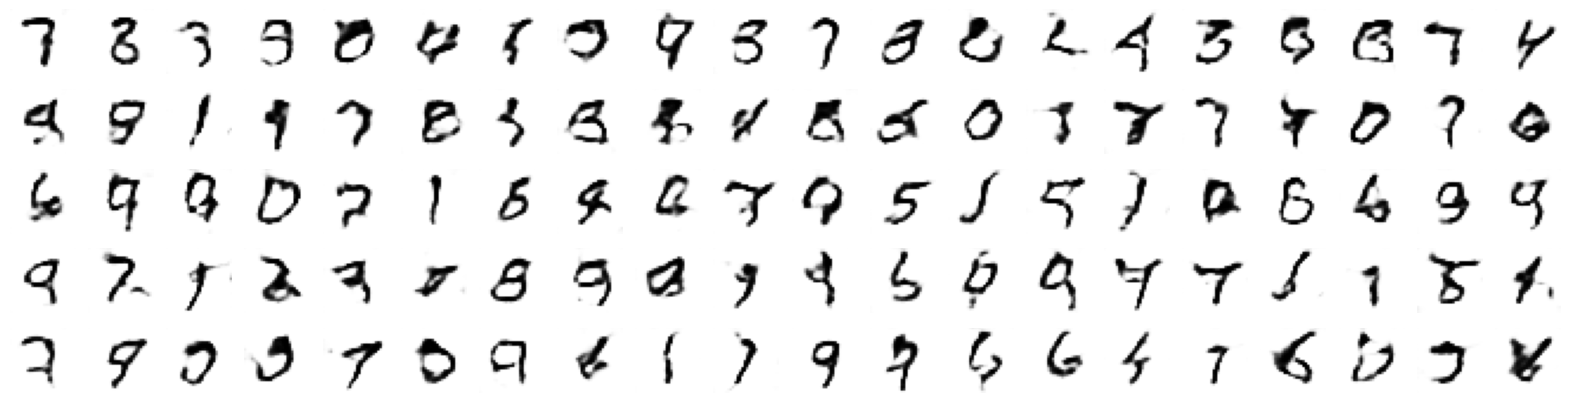

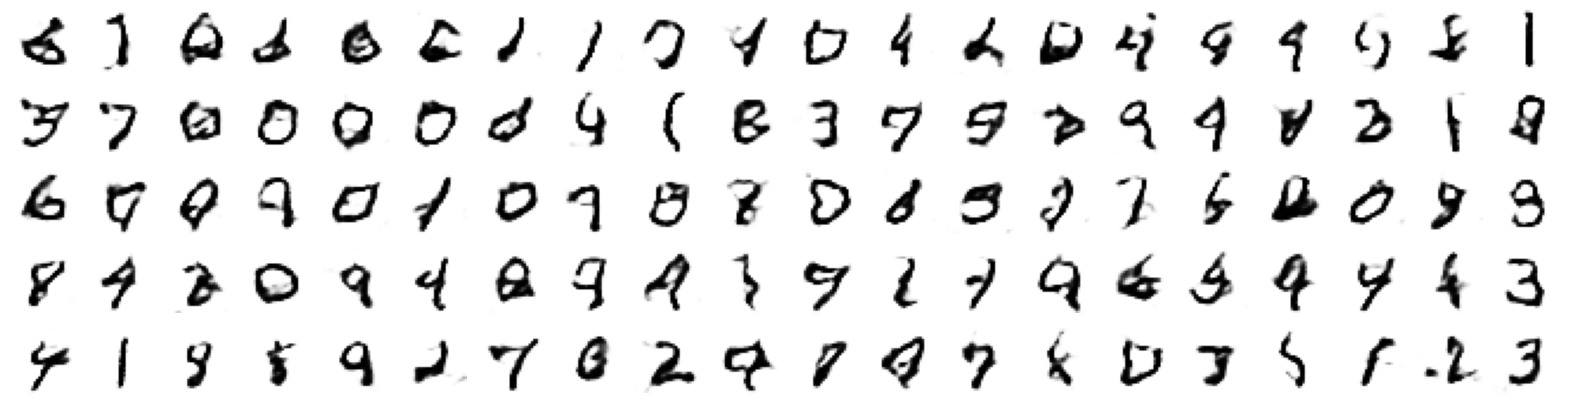

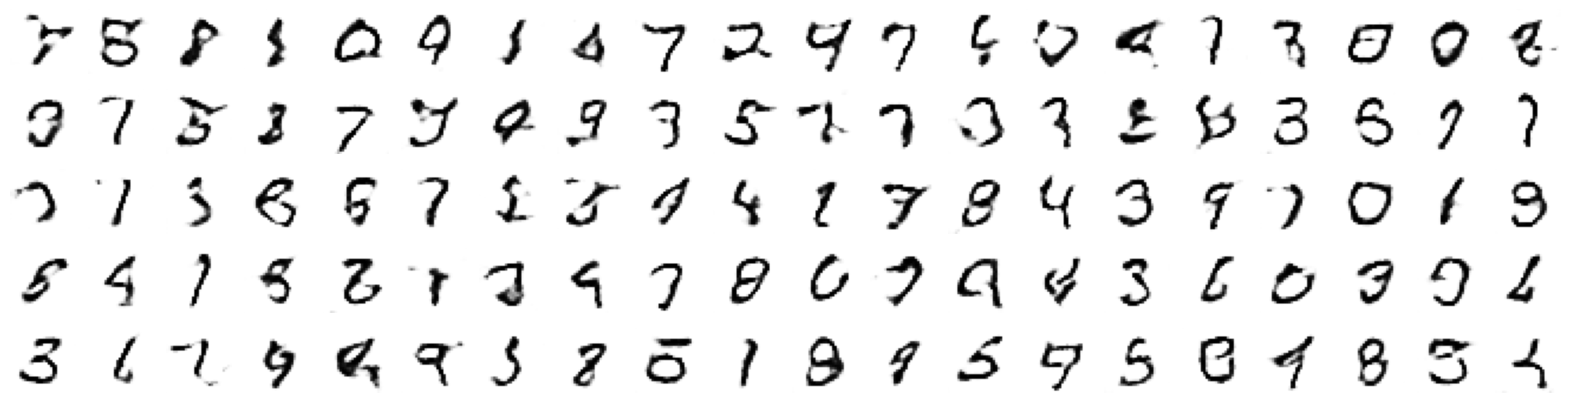

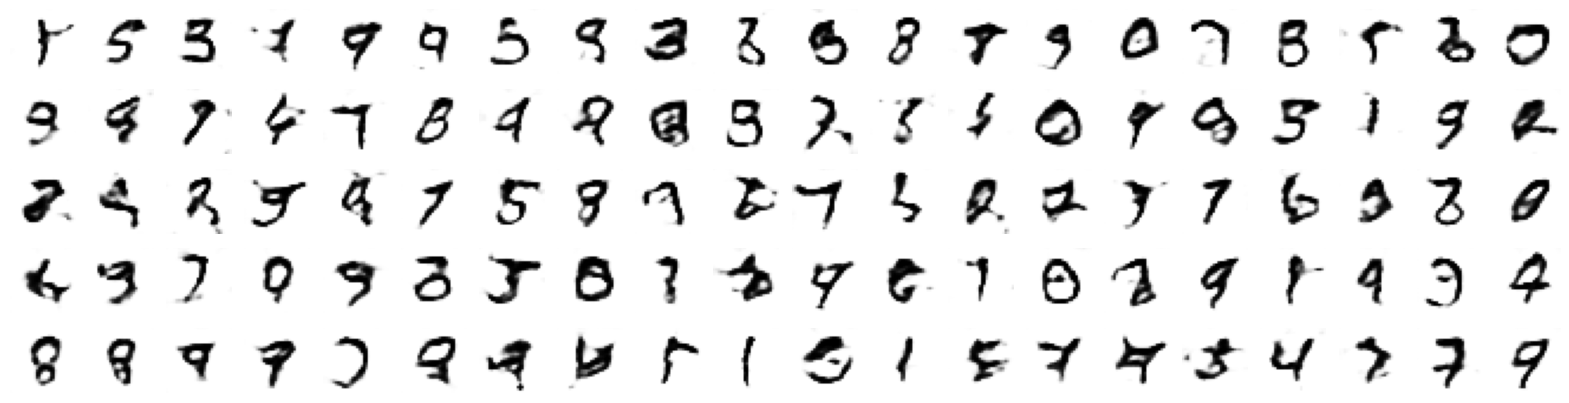

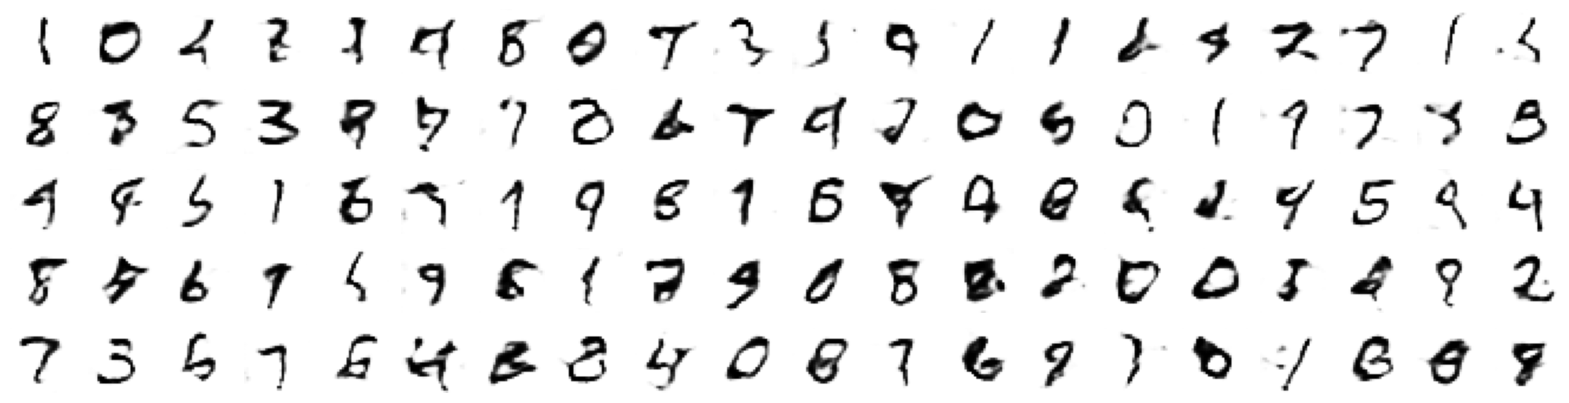

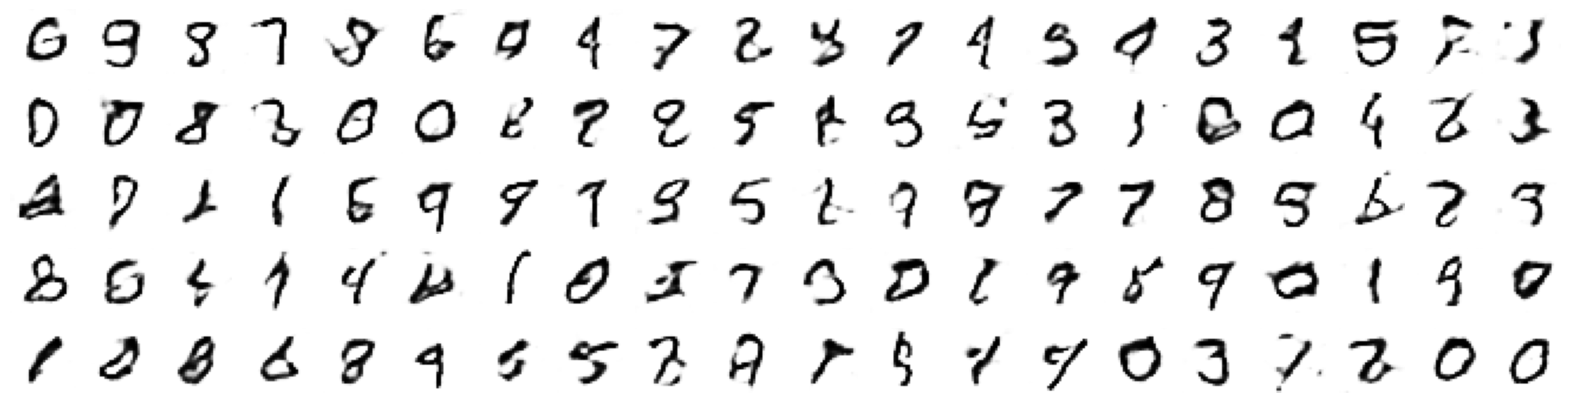

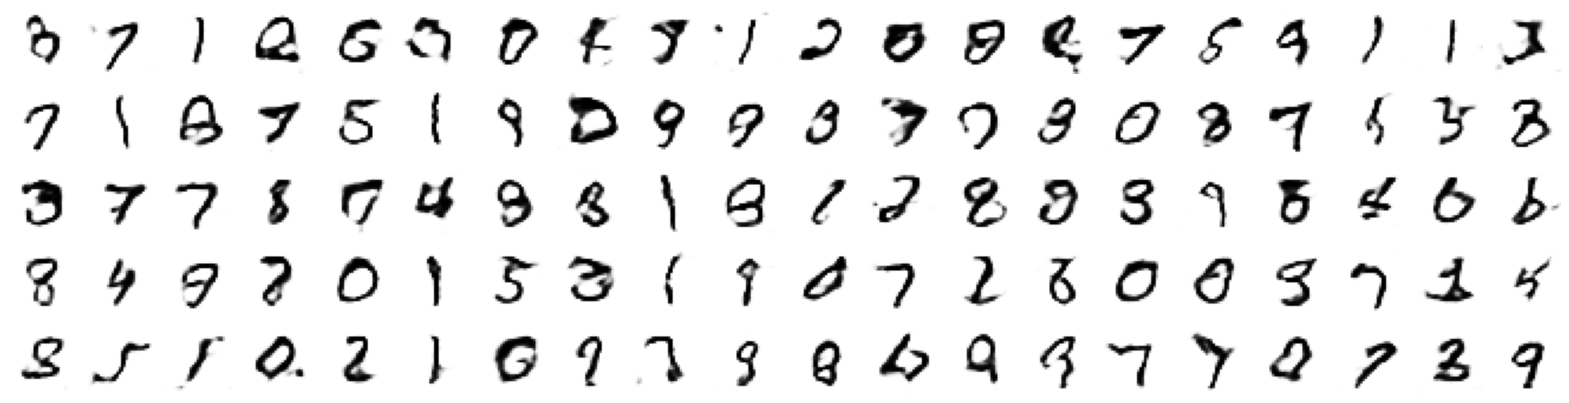

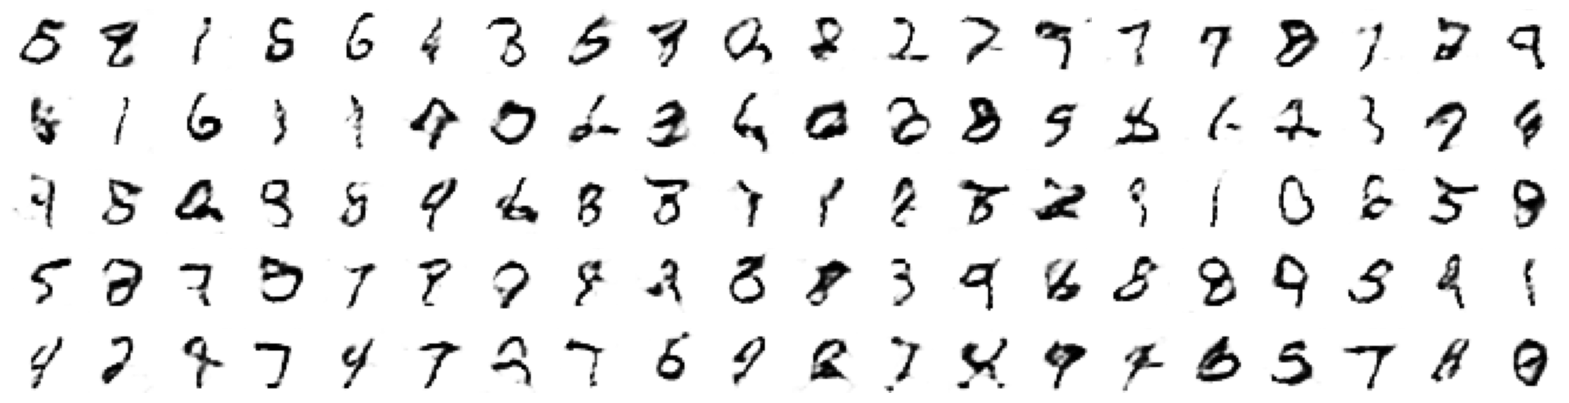

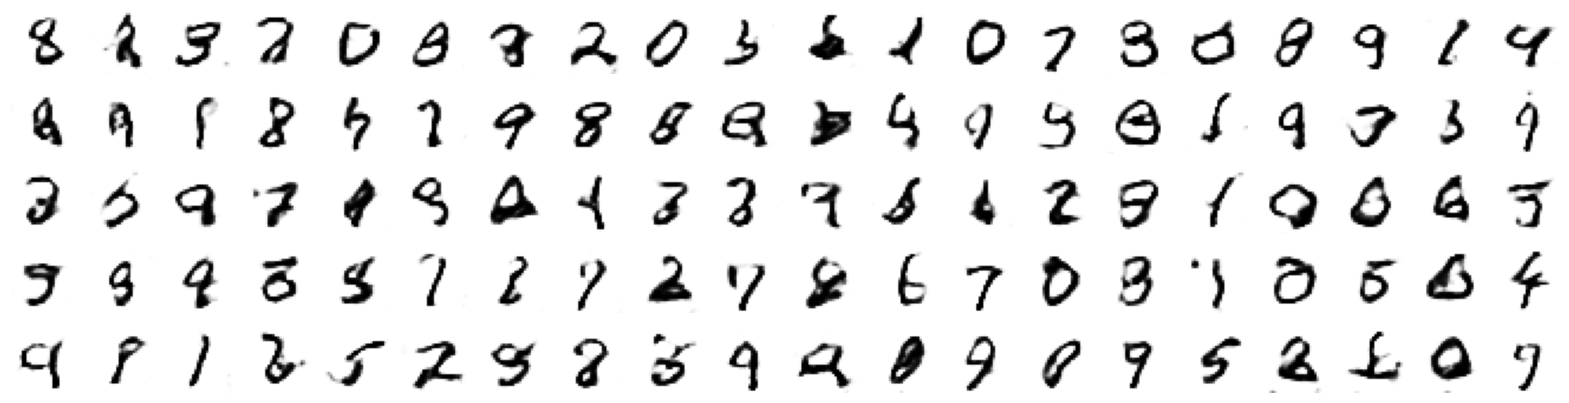

In [52]:
# Okay, let's train the model
train(dataset, EPOCHS)

<h3>Notice anything?</h3>

<p>You likely noticed that it seems as if the image generation was improving in quality for a while, and in the last 20 or so epochs, it leveled off and in many cases worsened. There is a fundamental flaw with the approach we have taken. Since the generator is trying to trick the discriminator into thinking it has created MNIST images, it will necessarily tend toward creating images that appear similar to the discriminator struggles with from among the actual MNIST images, namely those that are not very clear. We want the opposite! We want the generator to create images that are as clear as possible!

Here is how we can begin to address this issue.

We can train the GAN using only clear images, which we can identify by first training a simple classifier, and then picking a probability threshold, and selecting only the images that are classified correctly with a probability above the chosen threshold. That way, we are using the ones that classifier find easy to classify (i.e., the clearest images).</p>



In [91]:
# Let's make a simple CNN to classify the images
from tensorflow.keras.datasets import mnist

# First, we need to import the MNIST dataset and normalize the images
X_train, X_test = mnist.load_data()
y_train = X_train[1]
y_test = X_test[1]

X_train = X_train[0] / 255.0
X_test = X_test[0] / 255.0

# We also need to reshape the images to be 28x28x1
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Now we can make the model
mnist_classifier = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


In [92]:
# Compile the model
mnist_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
mnist_classifier.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1507 - accuracy: 0.9537
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0457 - accuracy: 0.9858
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0316 - accuracy: 0.9895
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0249 - accuracy: 0.9919
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0187 - accuracy: 0.9939


In [93]:
# Let's see how the model does on the test set
mnist_classifier.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0281 - accuracy: 0.9907


[0.028137020766735077, 0.9907000064849854]

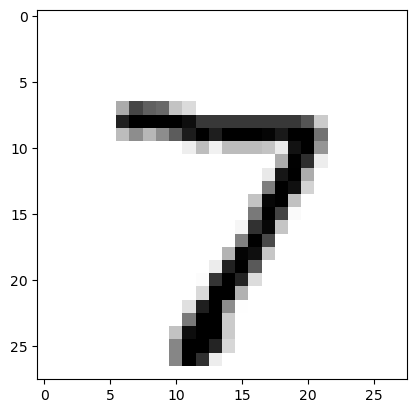

1/1 [==============================] - 0s 66ms/step


7

In [94]:
# Let's try the model on one of the test images
plt.imshow(X_test[0, :, :, 0], cmap='binary')
plt.show()

# Let's see what the model predicts (it should be a 7)
mnist_classifier.predict(X_test[0].reshape(1, 28, 28, 1)).argmax()

In [95]:
# Let's now use the classifier to extract the images from MNIST that were correctly classified,
# and that also have the highest probability when they were classified. Then we can use those
# images to train the GAN, and hopefully get some clearer images.

# First, we need to get the correct predictions from the classifier, as well as the probabilities
# for each class. So let's make the predictions, then select the predictions where the argmax (which
# will be the predicted class) is equal to the true class.
predictions = mnist_classifier.predict(X_train)

# Let's restrict things further by only selecting the images that have the highest probability
# above a certain threshold. We will use a threshold of 0.999999.
best_predictions = X_train[np.max(predictions, axis=1) > 0.999999]

1875/1875 [==============================] - 6s 3ms/step


In [105]:
# Now every prediction in best_predictions is a correctly classified image with a probability
# of at least 0.999999. Let's see how many images we have.
best_predictions.shape

(15313, 28, 28, 1)

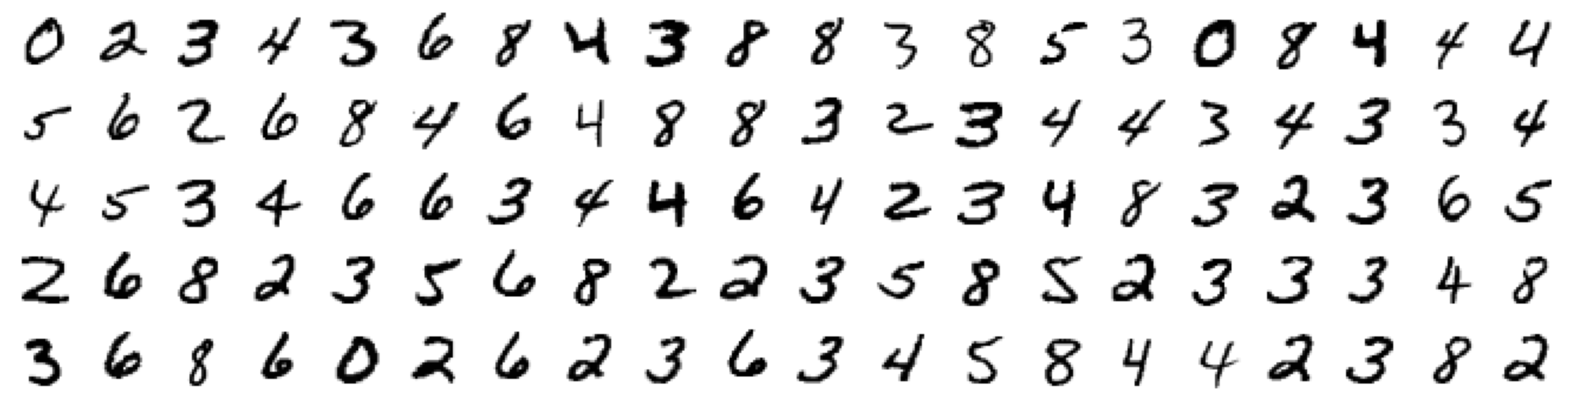

In [98]:
# Let's see what the first 100 images look like to make sure the clarity is what we 
# are hoping for.
fig = plt.figure(figsize=(20, 5))
for i in range(100):
    plt.subplot(5, 20, i + 1)
    plt.imshow(best_predictions[i, :, :, 0] * 255.0, cmap='binary')
    plt.axis('off')

plt.show()

<h3>Looks good! Let's retrain the GAN!</h3>

<p> Our training set has certainly shrunk a bit, but we should still be able to train a decent GAN. Let's see how it goes.</p>